# PyTorchを使う
PyTorchは深層学習フレームワークの1つ。1からプログラムをするのに比べ簡単で、かつGPUを利用した計算ができる。ほかにもTensorFlow, Chainerなど多くのフレームワークがある。本格的なディープラーニングでは、事実上、このいずれかを利用することになる。

使うときには以下のようにする。

In [1]:
import torch

## PyTorchのデータ、モデルを置くデバイス
GPUで計算する場合には、データとモデルをGPUに置く必要がある。その場合には、次の device 変数を cuda にしておく。GPU を使わない場合には cpu にする。

In [ ]:
device = torch.device("cpu")

## 多クラスロジスティック回帰

PyTorchでは、変数は Tensor という型に入れる。numpyのデータからはfrom_numpy関数で変換できる。

In [2]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
M = iris.target_names.size # クラス(アヤメの種類)の数
D = iris.data.shape[1] # 特徴量の数
X = torch.from_numpy(iris.data).float().to(device)
C = torch.from_numpy(iris.target).to(device)

In [3]:
X_train = X[0::2] # 偶数番目
X_test = X[1::2] # 奇数番目
C_train = C[0::2]
C_test = C[1::2]

多クラスロジスティック回帰は、
<span id="multiclasslogistic">
\begin{aligned}
    \boldsymbol{z} &= \boldsymbol{x}^\top\boldsymbol{W}+\boldsymbol{b} \\
    \boldsymbol{y} &=\text{softmax}(\boldsymbol{z})
\end{aligned}
</span>
だった(ただし、この式の $\boldsymbol{x}$ は1で拡張されて**いない**)。まず $\boldsymbol{x}$ を $\boldsymbol{W}$ と $\boldsymbol{b}$ で線形変換して $\boldsymbol{z}$ を得る。次に $\boldsymbol{z}$ を softmax 関数に通して $\boldsymbol{y}$ を得るという手順であった。

PyTorchでは、このようなベクトル(テンソル)の変換の繰り返しでモデルを定義する。線形変換を計算する Linear, 対数 softmax を計算する LogSoftmax というモジュールをモデルに順番に追加する。このモデルのパラメータは、$D\times M$ 次元の行列 $\boldsymbol{W}$ と、$M$ 次元のベクトル $\boldsymbol{b}$ である。

In [4]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=D, out_features=M),
    torch.nn.LogSoftmax(dim=1)
).to(device)

損失関数は、自分で定義しなくとも最初からいろいろ用意されている。ロジスティック回帰の損失関数は負の対数尤度 (Negative Log Likelihood) なので NLLLoss という関数が使える。

In [5]:
crossEntropyLoss = torch.nn.NLLLoss() # 損失関数

PyTorchを使ったモデル学習の基本は次の通りである。

まず、forward (前向き) 計算を行う。入力から出力への向きのことを前向きと呼ぶ。ここでは $\boldsymbol{x}$ から $\boldsymbol{z}$ 、$\boldsymbol{z}$ から $\boldsymbol{y}$ の計算である。上で定義した model 関数を使うと、出力の計算(=forward計算)が行える。

出力がわかると、教師データとの関係から損失が計算できる。次に損失を計算する。上で定義した crossEntropyLoss 関数に、出力と教師データを与えると計算してくれる。

次に、最小化したい値(ここでは loss)に対してbackward (後向き) 計算を行う。ここで計算されているのは誤差と呼ばれる値である。多クラスロジスティック回帰の場合には、クラス $m$ の教師信号との誤差は $y_m-t_m$ である。第2回の課題(2)でやったように、 $E$ の勾配は
$\sum_k (y_{km}-t_{km})\boldsymbol{x}$ となる。つまり、誤差と入力の積によって勾配が計算できる。PyTorch の backward 関数は、各層の誤差を計算するのと同時に、その層への入力との積から勾配 grad を計算し、パラメータの中に保存する。なお計算した勾配は蓄積される仕様なので、backward計算の前にゼロクリアしている。

後は今までと同じように、勾配に学習係数をかけた値をパラメータから引けば1回の更新が終了する。

In [6]:
learning_rate = 0.1
step_num = 10000

for i in range(step_num):
    Y = model(X_train) # forward計算
    loss = crossEntropyLoss(Y, C_train) # 損失の計算
    W, b = model.parameters()
    if W.grad is not None:
        W.grad.data.zero_()
        b.grad.data.zero_()

    loss.backward() # backward計算
    # 勾配法
    W.data -= learning_rate * W.grad.data
    b.data -= learning_rate * b.grad.data

学習の済んだモデルにテストデータの入力を入れると各クラスの対数確率が得られる。対数確率が最大のクラスが認識結果となる。

In [7]:
def accuracy(model,X,C):
    Y = model(X)
    Y = Y.detach().cpu().numpy() # PyTorchテンソルからnumpy ndarrayに変換
    result = np.argmax(Y, axis=1)
    answer = C.detach().cpu().numpy()
    return np.mean(np.equal(result, answer))

In [8]:
accuracy(model, X_test, C_test)

0.9466666666666667

# 手書き数字の認識

アヤメの分類よりももう少しだけ本格的な問題を解いてみる。[MNIST](https://en.wikipedia.org/wiki/MNIST_database)は0から9までの手書き数字画像のデータベースである。これを使って、多クラスロジスティック回帰モデルで手書き数字の認識をやってみよう。

In [9]:
from sklearn.datasets import fetch_openml

mnist_X, mnist_C = fetch_openml('mnist_784', data_home=".", return_X_y=True)

X には0から255までの画素値、 C にはどの数字かを表す数値が入っている。まずXを最大値1に正規化する。

In [10]:
X = mnist_X.to_numpy(np.float32) / 255.0
C = mnist_C.to_numpy(np.int64)
X.shape

(70000, 784)

データ数は全部で70000個、特徴量の数は画素数($28\times28=784$)である。

以下のコードで、データの1つを描画できる。Xの添字を適当に変えて、MNISTがどのようなデータなのか眺めておこう。

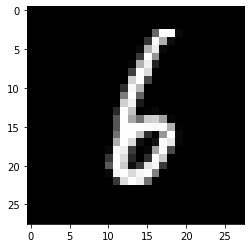

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X[23450].reshape(28,28), cmap='gray')

In [12]:
M = 10 # 数字の数
D = 28 * 28 # 特徴量の数

90%のデータで訓練、残り10%でテストする。

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, C_train, C_test = train_test_split(X, C, test_size=0.1, random_state=0)

モデル定義はirisの時と同じ。

In [14]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=D, out_features=M),
    torch.nn.LogSoftmax(dim=1)
).to(device)

学習部分については関数化しておこう。

In [15]:
def train(model, X, C, learning_rate=0.5, step_num=100):
    for i in range(step_num):
        Y = model(X) # forward計算
        loss = crossEntropyLoss(Y, C) # 損失の計算
        W, b = model.parameters()
        if W.grad is not None:
            W.grad.data.zero_()
            b.grad.data.zero_()

        loss.backward() # backward計算
        # 勾配法
        W.data -= learning_rate * W.grad.data
        b.data -= learning_rate * b.grad.data
        print("epoch {}: loss = {}".format(i+1,loss))

では学習してみよう。

In [16]:
X_train_t = torch.from_numpy(X_train).to(device)
C_train_t = torch.from_numpy(C_train).to(device)
train(model, X_train_t, C_train_t, step_num=200)

epoch 1: loss = 2.2661890983581543
epoch 2: loss = 1.8042733669281006
epoch 3: loss = 1.4957891702651978
epoch 4: loss = 1.2897237539291382
epoch 5: loss = 1.1467643976211548
epoch 6: loss = 1.0422625541687012
epoch 7: loss = 0.9632754325866699
epoch 8: loss = 0.9013505578041077
epoch 9: loss = 0.8517554402351379
epoch 10: loss = 0.8105382323265076
epoch 11: loss = 0.7762312293052673
epoch 12: loss = 0.7467442750930786
epoch 13: loss = 0.7214733362197876
epoch 14: loss = 0.6993616819381714
epoch 15: loss = 0.6799502968788147
epoch 16: loss = 0.6626967787742615
epoch 17: loss = 0.6472556591033936
epoch 18: loss = 0.6333234310150146
epoch 19: loss = 0.6206725239753723
epoch 20: loss = 0.6091181635856628
epoch 21: loss = 0.5985129475593567
epoch 22: loss = 0.5887360572814941
epoch 23: loss = 0.5796873569488525
epoch 24: loss = 0.5712826251983643
epoch 25: loss = 0.5634509921073914
epoch 26: loss = 0.5561316609382629
epoch 27: loss = 0.5492722988128662
epoch 28: loss = 0.542827844619751
ep

正解率を調べる。

In [17]:
X_test_t = torch.from_numpy(X_test).to(device)
C_test_t = torch.from_numpy(C_test).to(device)
accuracy(model, X_test_t, C_test_t)

0.9032857142857142

## ミニバッチ学習
ここまでは、全データで一挙に重みを更新した。これをバッチ学習という。これに対し、深層学習の世界では、全データをいくつかのミニバッチに分割して勾配降下法を実行するSGD(確率的勾配降下法)、またの名をミニバッチ学習という学習方法がよく使われる。この方法は、収束が速く、局所最小値にはまる危険が少ない特長を持っている。

PyTorchでは、DataLoaderという機能を使うとデータを自動的にミニバッチに分割してくれる。この機能を使うために、まずMNIST用にデータセットを定義しておく。

In [18]:
from torch.utils.data import Dataset, DataLoader

class MNISTTrainDataSet(Dataset):
    def __len__(self):
        return X_train.shape[0]
    
    def __getitem__(self, idx):
        return X_train[idx].astype('float'), C_train[idx]

今回のDataLoaderでは、バッチサイズを50とする。つまり、70000個のデータを50個ずつに分割し、それぞれで勾配降下法によりパラメータを更新する。これを全データに対して行う。全データを1回なめることを1エポックという。

In [19]:
mnist = MNISTTrainDataSet()
train_loader = DataLoader(dataset=mnist,batch_size=50,shuffle=True)

モデルは上と同じ。

In [20]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=D, out_features=M),
    torch.nn.LogSoftmax(dim=1)
).to(device)

学習部分は以下のようになる。

In [21]:
def train(model, learning_rate=0.5, num_epochs=100):
    for epoch in range(num_epochs):
        for X, C in train_loader:
            X = X.float() # DataLoaderはデータをdouble型で渡すので、後の処理のためにfloat型に変換
            X, C = X.to(device), C.to(device)
            Y = model(X) # forward計算
            loss = crossEntropyLoss(Y, C) # 損失の計算
            W, b = model.parameters()
            if W.grad is not None:
                W.grad.data.zero_()
                b.grad.data.zero_()

            loss.backward() # backward計算
            # 勾配法
            W.data -= learning_rate * W.grad.data
            b.data -= learning_rate * b.grad.data
        Y = model(X_train_t)
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, crossEntropyLoss(Y, C_train_t)))

In [22]:
train(model,learning_rate=0.1)

Epoch [1/100], Loss: 0.3358
Epoch [2/100], Loss: 0.3056
Epoch [3/100], Loss: 0.2921
Epoch [4/100], Loss: 0.2842
Epoch [5/100], Loss: 0.2784
Epoch [6/100], Loss: 0.2756
Epoch [7/100], Loss: 0.2706
Epoch [8/100], Loss: 0.2693
Epoch [9/100], Loss: 0.2662
Epoch [10/100], Loss: 0.2635
Epoch [11/100], Loss: 0.2649
Epoch [12/100], Loss: 0.2602
Epoch [13/100], Loss: 0.2588
Epoch [14/100], Loss: 0.2591
Epoch [15/100], Loss: 0.2568
Epoch [16/100], Loss: 0.2557
Epoch [17/100], Loss: 0.2553
Epoch [18/100], Loss: 0.2565
Epoch [19/100], Loss: 0.2554
Epoch [20/100], Loss: 0.2521
Epoch [21/100], Loss: 0.2546
Epoch [22/100], Loss: 0.2519
Epoch [23/100], Loss: 0.2508
Epoch [24/100], Loss: 0.2502
Epoch [25/100], Loss: 0.2492
Epoch [26/100], Loss: 0.2476
Epoch [27/100], Loss: 0.2478
Epoch [28/100], Loss: 0.2462
Epoch [29/100], Loss: 0.2474
Epoch [30/100], Loss: 0.2481
Epoch [31/100], Loss: 0.2462
Epoch [32/100], Loss: 0.2476
Epoch [33/100], Loss: 0.2446
Epoch [34/100], Loss: 0.2441
Epoch [35/100], Loss: 0

In [23]:
accuracy(model, X_test_t, C_test_t)

0.924

## Feed-forwardネットワーク
多クラスロジスティック回帰を少し拡張してみる。(記号を少し変えてある)
\begin{aligned}
\boldsymbol{a}_1&=\boldsymbol{x}^\top\boldsymbol{W}^{(1)}+\boldsymbol{b}^{(1)}\\
\boldsymbol{z}_1&=\sigma(\boldsymbol{a}_1) \\
\boldsymbol{a}_2&={\boldsymbol{z}_1}^\top\boldsymbol{W}^{(2)} +\boldsymbol{b}^{(2)}\\
\boldsymbol{y}&=\text{softmax}(\boldsymbol{a}_2)
\end{aligned}
$\boldsymbol{x}$ → $\boldsymbol{z_1}$ → $\boldsymbol{y}$ の順でデータが変換されているのがわかるだろうか。

$\boldsymbol{W}^{(1)}$ は $D\times H$行列、$\boldsymbol{b}^{(1)}$ は $H$次元ベクトル、$\boldsymbol{W}^{(2)}$ は $H\times M$行列、$\boldsymbol{b}^{(2)}$ は $M$次元ベクトルである。(プラス1は切片のため)  $\boldsymbol{z}^+$ は $\boldsymbol{z}$ を1で拡張したベクトルを表す。$H$ は任意に決められるが、この数が重要であることが後でわかる。

$\sigma(\cdot)$ はロジスティック関数であり、上式の $\boldsymbol{z}_1=\sigma(\boldsymbol{a}_1)$ とは $\boldsymbol{a}_1$ の各次元の値をロジスティック関数に通した値をつなげてベクトルにするという意味である。この関数は、PyTorchでは torch.nn.Sigmoid() として提供されている。

In [25]:
hidden_units = 500
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=D, out_features=hidden_units),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features=hidden_units, out_features=M),
    torch.nn.LogSoftmax(dim=1)
)

In [24]:
def train(model, learning_rate=0.5, num_epochs=100):
    for epoch in range(num_epochs):
        for X, C in train_loader:
            X = X.float() # DataLoaderはデータをdouble型で渡すので、後の処理のためにfloat型に変換
            X, C = X.to(device), C.to(device)
            Y = model(X) # forward計算
            loss = crossEntropyLoss(Y, C) # 損失の計算
            W1, b1, W2, b2 = model.parameters()
            if W1.grad is not None:
                W1.grad.data.zero_()
                b1.grad.data.zero_()
            if W2.grad is not None:
                W2.grad.data.zero_()
                b2.grad.data.zero_()
            loss.backward() # backward計算
            # 勾配法
            W1.data -= learning_rate * W1.grad.data
            b1.data -= learning_rate * b1.grad.data
            W2.data -= learning_rate * W2.grad.data
            b2.data -= learning_rate * b2.grad.data

        Y = model(X_train_t)
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, crossEntropyLoss(Y, C_train_t)))

In [26]:
train(model,learning_rate=0.5)

Epoch [1/100], Loss: 0.2538
Epoch [2/100], Loss: 0.1752
Epoch [3/100], Loss: 0.1417
Epoch [4/100], Loss: 0.1083
Epoch [5/100], Loss: 0.0928
Epoch [6/100], Loss: 0.0777
Epoch [7/100], Loss: 0.0702
Epoch [8/100], Loss: 0.0567
Epoch [9/100], Loss: 0.0537
Epoch [10/100], Loss: 0.0437
Epoch [11/100], Loss: 0.0407
Epoch [12/100], Loss: 0.0348
Epoch [13/100], Loss: 0.0345
Epoch [14/100], Loss: 0.0281
Epoch [15/100], Loss: 0.0259
Epoch [16/100], Loss: 0.0276
Epoch [17/100], Loss: 0.0208
Epoch [18/100], Loss: 0.0189
Epoch [19/100], Loss: 0.0176
Epoch [20/100], Loss: 0.0160
Epoch [21/100], Loss: 0.0157
Epoch [22/100], Loss: 0.0129
Epoch [23/100], Loss: 0.0141
Epoch [24/100], Loss: 0.0110
Epoch [25/100], Loss: 0.0106
Epoch [26/100], Loss: 0.0102
Epoch [27/100], Loss: 0.0088
Epoch [28/100], Loss: 0.0093
Epoch [29/100], Loss: 0.0076
Epoch [30/100], Loss: 0.0071
Epoch [31/100], Loss: 0.0066
Epoch [32/100], Loss: 0.0065
Epoch [33/100], Loss: 0.0058
Epoch [34/100], Loss: 0.0056
Epoch [35/100], Loss: 0

In [27]:
accuracy(model, X_test_t, C_test_t)

0.9818571428571429

# 課題
1. Feed-forwardネットワークは、「多層パーセプトロン」という別名を持つ、もっとも基本的なニューラルネットである。ニューラルネットとは何か、なぜニューラルネットと呼ばれるのかについて、研究室の蔵書を読んでおくこと。(「これならわかる深層学習入門」がおすすめ)
1. (重要) Feed-forwardネットワークにより手書き数字画像のモデル化を行い、多クラスロジスティック回帰と性能を比較せよ。隠れ層ユニットの数 (${}=H$) について、いろいろ試してみよ。
1. $\boldsymbol{x}$ から $\boldsymbol{a}$ へは線形変換、 $\boldsymbol{a}$ から $\boldsymbol{z}$ へは非線形変換になっている。もし $\boldsymbol{a}$ から $\boldsymbol{z}$ が線形変換であれば、このモデルは多クラスロジスティック回帰と等価になってしまう。なぜか。